In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!wget 'https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip'

--2024-10-29 22:45:16--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  67.43M   219MB/s    in 0.3s    

2024-10-29 22:45:17 (219 MB/s) - ‘cats_and_dogs.zip’ saved [70702765/70702765]



In [ ]:
!unzip cats_and_dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [ ]:

!rm cats_and_dogs.zip

In [ ]:
!rm -rf __MACOSX


In [ ]:
PATH = 'cats_and_dogs'

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
train_dir      = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir       = os.path.join(PATH, 'test')

# -1 because of DS_Store
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])-1
total_val   = sum([len(files) for r, d, files in os.walk(validation_dir)])-1
total_test  = len(os.listdir(test_dir))-1

print('Train:', total_train)
print('Validation:', total_val)
print('Test:', total_test)

Train: 2000
Validation: 1000
Test: 50


In [ ]:
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator       = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
                    train_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary')

val_data_gen   = validation_image_generator.flow_from_directory(
                    validation_dir,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    class_mode='binary')

test_data_gen  = test_image_generator.flow_from_directory(
                    PATH,
                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                    batch_size=batch_size,
                    classes=['test'],
                    shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


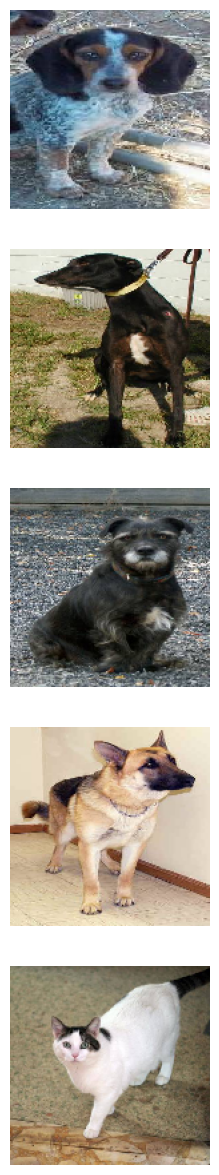

In [ ]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            horizontal_flip=True,
                            rotation_range=20,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15,
                            fill_mode="nearest")

Found 2000 images belonging to 2 classes.


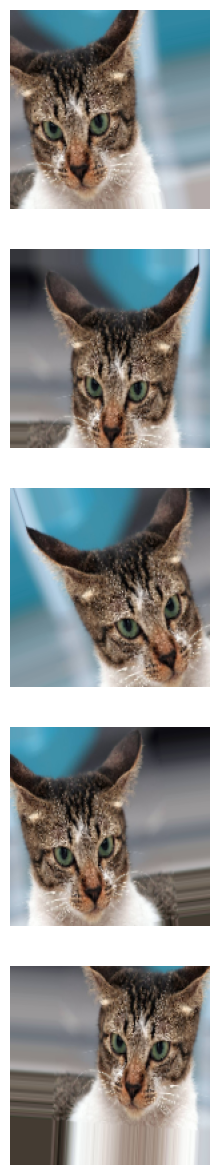

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
model = Sequential()

# Convolutions
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Conv2D(32, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

train_steps = int(ceil(1. * total_train / batch_size))
val_steps   = int(ceil(1. * total_val / batch_size))

print(train_steps, val_steps)

16 8


In [ ]:
history = model.fit(
            train_data_gen, #steps_per_epoch=train_steps,
            validation_data=val_data_gen, #validation_steps=val_steps,
            epochs=epochs)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.4914 - loss: 2.3804 - val_accuracy: 0.5460 - val_loss: 0.6824
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 140s 8s/step - accuracy: 0.5414 - loss: 0.6817 - val_accuracy: 0.6010 - val_loss: 0.6510
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 9s/step - accuracy: 0.5844 - loss: 0.6663 - val_accuracy: 0.6110 - val_loss: 0.6396
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 197s 8s/step - accuracy: 0.5972 - loss: 0.6607 - val_accuracy: 0.6470 - val_loss: 0.6266
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 8s/step - accuracy: 0.5990 - loss: 0.6623 - val_accuracy: 0.6250 - val_loss: 0.6284
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 8s/step - accuracy: 0.6154 - loss: 0.6446 - val_accuracy: 0.6150 - val_loss: 0.6461
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 148s 9s/step - accuracy: 0.5900 - loss: 0.6690 - val_accuracy: 0.5720 - val_loss: 0.6511
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 196s 8s/step - accuracy: 0.6385 - loss: 0.6314 - val_accuracy: 0.6600 - val_loss: 0.

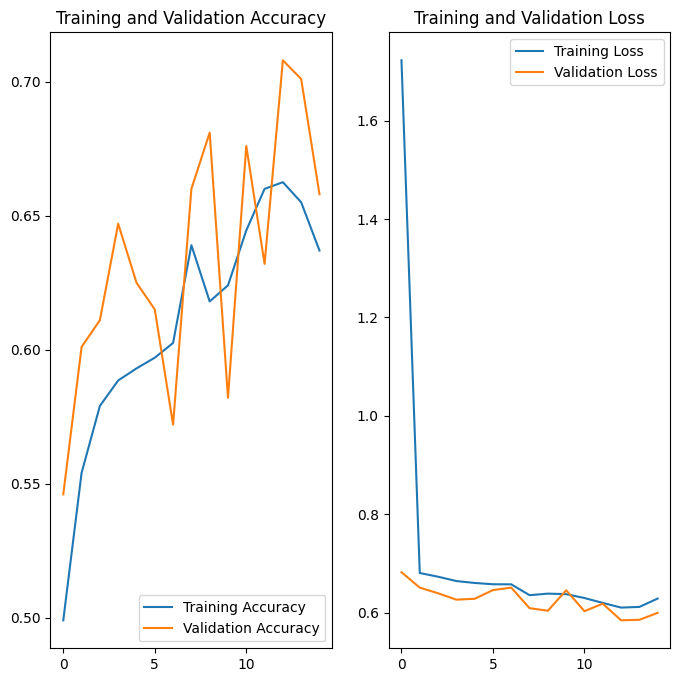

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
probabilities = model.predict(test_data_gen).flatten()
probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([0.44500595, 0.34605554, 0.33452684, 0.747002  , 0.52026296,
       0.6217297 , 0.6641839 , 0.46749914, 0.42222515, 0.8620833 ,
       0.6139226 , 0.7099068 , 0.4567382 , 0.31830952, 0.6519336 ,
       0.6234109 , 0.5750679 , 0.7164594 , 0.71503407, 0.5929613 ,
       0.36809185, 0.7774265 , 0.3598303 , 0.7754078 , 0.75531864,
       0.5936886 , 0.8566124 , 0.49698502, 0.50119835, 0.5744285 ,
       0.5521556 , 0.4522489 , 0.7537663 , 0.9988409 , 0.35250193,
       0.5710653 , 0.9840987 , 0.632814  , 0.6591602 , 0.47959974,
       0.57223207, 0.5068707 , 0.8066686 , 0.45269948, 0.5671039 ,
       0.48179945, 0.4689822 , 0.46607557, 0.28794798, 0.52461296],
      dtype=float32)

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {int(round(percentage_identified, 2)*100)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 64% of the images of cats and dogs.
You passed the challenge!
